In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/fruits2.zip','r')
zip_ref.extractall()
zip_ref.close()

In [3]:
import os
import shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader



In [4]:
IMAGE_SIZE = 256
PATCH_SIZE = 16

In [5]:
# Verify Images Function
def verify_images(directory):
    broken_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f" Corrupted image: {file_path} | Error: {e}")
                broken_images.append(file_path)
    return broken_images


In [19]:
# Train/Validation Split
def split_dataset(base_dir, val_ratio=0.15):
    val_base_dir = os.path.join(os.path.dirname(base_dir), "Validation")

    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) == 0:
            print(f"⚠ No images found in {cls_path}")
            continue

        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        val_dir = os.path.join(val_base_dir, cls)
        os.makedirs(val_dir, exist_ok=True)

        for img in val_imgs:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_dir, img))

        print(f"✅ Moved {len(val_imgs)} images to {val_dir}")


In [7]:
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]


In [8]:

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to 224x224 for ViT
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=mean_vals, std=std_vals)  # Normalize
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])


In [9]:
# Load Dataset
def load_datasets(train_path, val_path):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, train_dataset.classes


In [10]:
# Convert Image Batch to ViT Patches
def image_to_patches(img_batch, patch_size):
    B, C, H, W = img_batch.shape  # Batch Size, Channels, Height, Width
    patches = img_batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(B, -1, C * patch_size * patch_size)
    return patches  # Shape: (Batch, Num_Patches, Flattened Patch Size)


In [11]:
# Display Sample Images with Patches
def imshow_batch(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    def unnormalize(img):
        std_tensor = torch.tensor(std_vals).view(3, 1, 1)
        mean_tensor = torch.tensor(mean_vals).view(3, 1, 1)
        img = img * std_tensor + mean_tensor  # Reverse normalization
        return img.clamp(0, 1)  # Clip values between 0-1

    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i in range(8):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()
# Convert to Patches for ViT
    patches = image_to_patches(images, PATCH_SIZE)
    print(f"Patches Shape: {patches.shape}")  # (Batch, Num_Patches, Flattened Patch Size)

# Run Pipeline
dataset_path = "/content/fruits2"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Test")




✅ Moved 23 images to /content/fruits2/Validation/rottenbanana
✅ Moved 23 images to /content/fruits2/Validation/freshapple
✅ Moved 23 images to /content/fruits2/Validation/rottenapple
✅ Moved 23 images to /content/fruits2/Validation/freshbanana


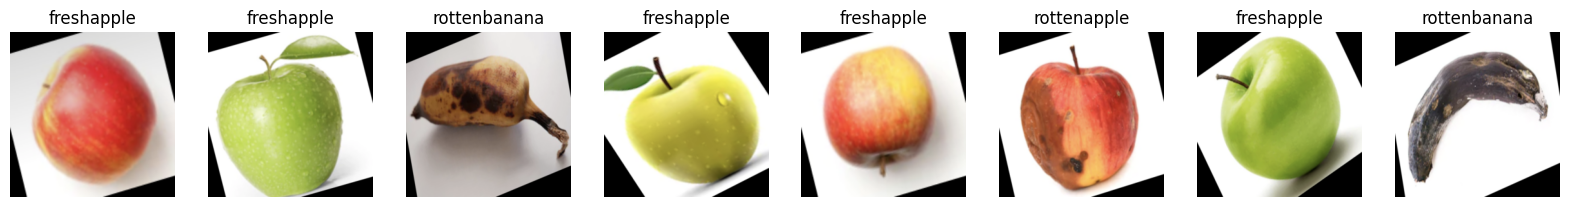

Patches Shape: torch.Size([8, 256, 768])


In [12]:
# Verify images
corrupt_files = verify_images(dataset_path)
if corrupt_files:
    print(f"⚠ Found {len(corrupt_files)} corrupt images.")

# Split dataset
split_dataset(train_path, val_ratio=0.15)

# Load dataset
train_loader, val_loader, class_names = load_datasets(train_path, val_path)

# Show batch of images and their patches
imshow_batch(train_loader, class_names) # Removed the non-breaking space before class_names

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm

In [14]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ViT preprocessing parameters
image_size = 224  # ViT expects 224x224 images
mean_vals = [0.5, 0.5, 0.5]
std_vals = [0.5, 0.5, 0.5]


# Define data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

In [16]:

# Load dataset
train_dir = "/content/fruits2/Train"
test_dir = "/content/fruits2/Test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print(train_dataset.class_to_idx)

# Check and adjust the number of classes in your model
num_classes = len(train_dataset.classes) # Get the actual number of classes
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model.to(device)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



{'freshapple': 0, 'freshbanana': 1, 'rottenapple': 2, 'rottenbanana': 3}


In [17]:
# Training loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [18]:
# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Train and evaluate the model
train_model(model, train_loader, epochs=3)
evaluate_model(model, test_loader)

Epoch [1/3], Loss: 0.3996
Epoch [2/3], Loss: 0.0115
Epoch [3/3], Loss: 0.0003
Test Accuracy: 100.00%


In [23]:

def predict_fruit(image_path):
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Perform prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        # Get the prediction result
        return class_names[predicted.item()]

    except Exception as e:
        return f"Error processing the image: {e}"

# Main function for user input
def main():
    image_path = input("Enter the path to the fruit image: ")
    if not image_path:
        print(" Please provide a valid image path.")
        return

    prediction = predict_fruit(image_path)
    print(f"Prediction: The fruit is {prediction}.")

if __name__ == "__main__":
    main()

Enter the path to the fruit image: /content/a2.jpg
Prediction: The fruit is rottenapple.


Enter the paths to the fruit images, separated by commas: /content/a1.jpeg,/content/a2.jpg,/content/b1.jpeg,/content/b2.jpeg
Processing image 1: /content/a1.jpeg
Prediction for image 1: The fruit is freshapple.


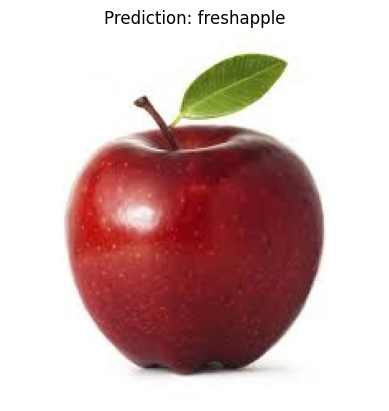

Processing image 2: /content/a2.jpg
Prediction for image 2: The fruit is rottenapple.


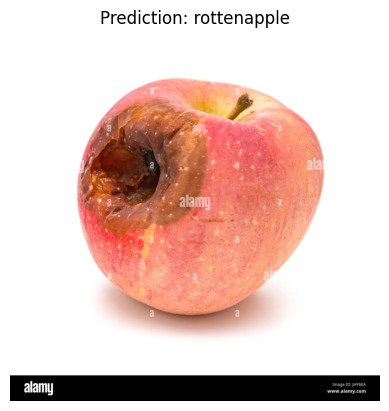

Processing image 3: /content/b1.jpeg
Prediction for image 3: The fruit is freshbanana.


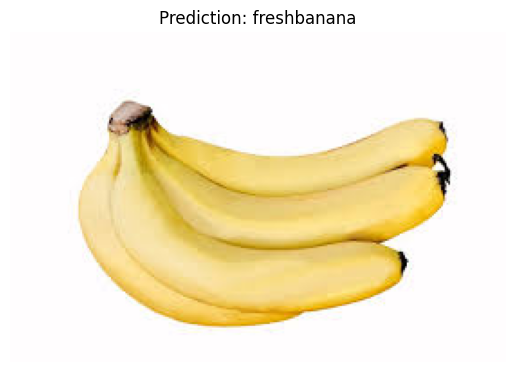

Processing image 4: /content/b2.jpeg
Prediction for image 4: The fruit is rottenbanana.


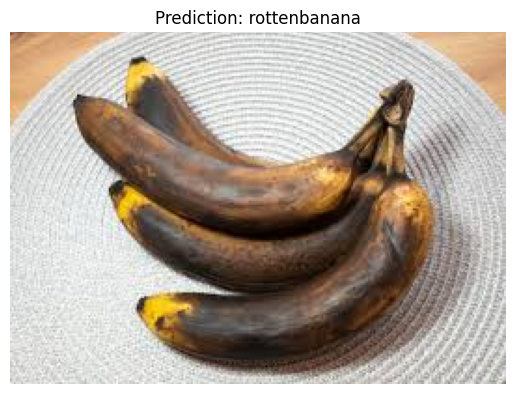

In [32]:


# Main function for user input
def main():
    image_paths = input("Enter the paths to the fruit images, separated by commas: ")
    if not image_paths:
        print("Please provide valid image paths.")
        return

    image_paths = [path.strip() for path in image_paths.split(",")]  # Split and clean paths

    for idx, image_path in enumerate(image_paths):
        print(f"Processing image {idx + 1}: {image_path}")
        prediction, img = predict_fruit(image_path)
        print(f"Prediction for image {idx + 1}: The fruit is {prediction}.")

        if img:
            # Display the image along with the prediction
            plt.imshow(img)
            plt.title(f"Prediction: {prediction}")
            plt.axis('off')
            plt.show()

if __name__ == "__main__":
    main()
